In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import datetime
import pandas as pd

from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *
from calendar import monthrange

from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

In [2]:
ds = xr.open_mfdataset("/scratch/summit/erke2265/PRODUCTION/*WN/output/grids/*")

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [3]:
n_trim = 15 # 15
ds = ds.isel(easting=slice(n_trim, -n_trim))
ds = ds.isel(northing=slice(n_trim, -n_trim))

# Transect of topography slope

In [4]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

In [5]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

In [6]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

In [7]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

In [8]:
# Load slope
slope = np.flipud(np.loadtxt("/scratch/summit/erke2265/SNOWPACK_WAIS/input/surface-grids/slope.asc", skiprows=6))
slope = slope[n_trim:-n_trim, n_trim:-n_trim]
slope = xr.DataArray(slope, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])

# Load DEM
dem = np.flipud(np.loadtxt("/scratch/summit/erke2265/SNOWPACK_WAIS/input/surface-grids/dem.asc", skiprows=6))
dem = dem[n_trim:-n_trim, n_trim:-n_trim]
dem = xr.DataArray(dem, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])

In [9]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

slope_transect =  slope.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# Indices to plot
ind0 = 660
indf = 2000
indices = np.arange(ind0, indf)

In [10]:
# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

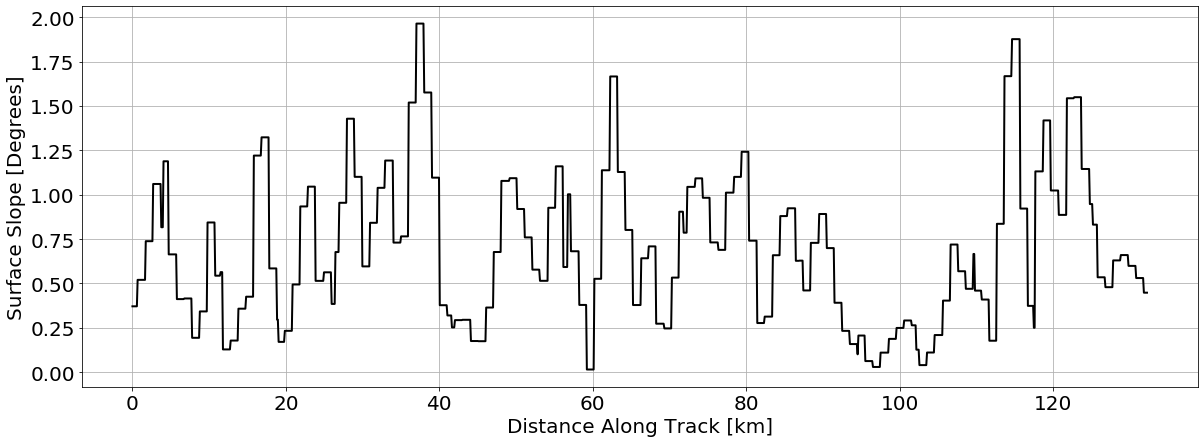

In [11]:
plt.figure(figsize=(20,7))
plt.plot(dat, slope_transect[indices], 'k', linewidth=2)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Surface Slope [Degrees]", fontsize=20)
plt.xlabel("Distance Along Track [km]", fontsize=20)
plt.savefig('images/slope_transect.pdf', format='pdf', dpi=100)

# Transect of 10 m wind speed

In [12]:
mean_ws = ds['ws'].mean(dim='time')

In [13]:
ws_transect = mean_ws.sel(northing=tgt_y, easting=tgt_x, method='nearest')

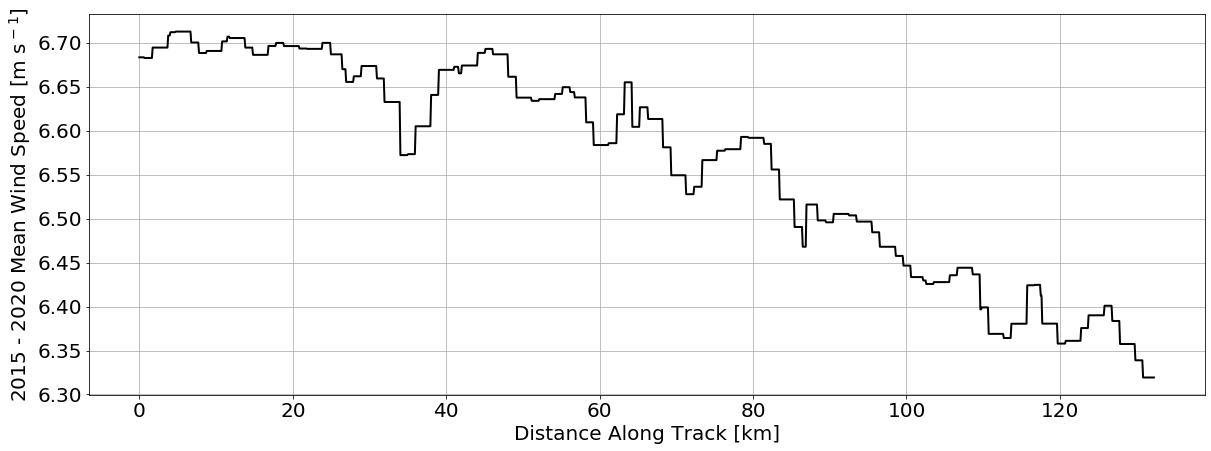

In [14]:
plt.figure(figsize=(20,7))
plt.plot(dat, ws_transect[indices], 'k', linewidth=2)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("2015 - 2020 Mean Wind Speed [m s$^-$$^1$]", fontsize=20)
plt.xlabel("Distance Along Track [km]", fontsize=20)
plt.savefig('images/ws_transect.pdf', format='pdf', dpi=100)

# Transect of of erosion deposition

In [15]:
n_years = 2020 - 2015 + 1
ed = ds['WINDEROSIONDEPOSITION'].sum(dim='time') / n_years
ed_transect = ed.sel(northing=tgt_y, easting=tgt_x, method='nearest')

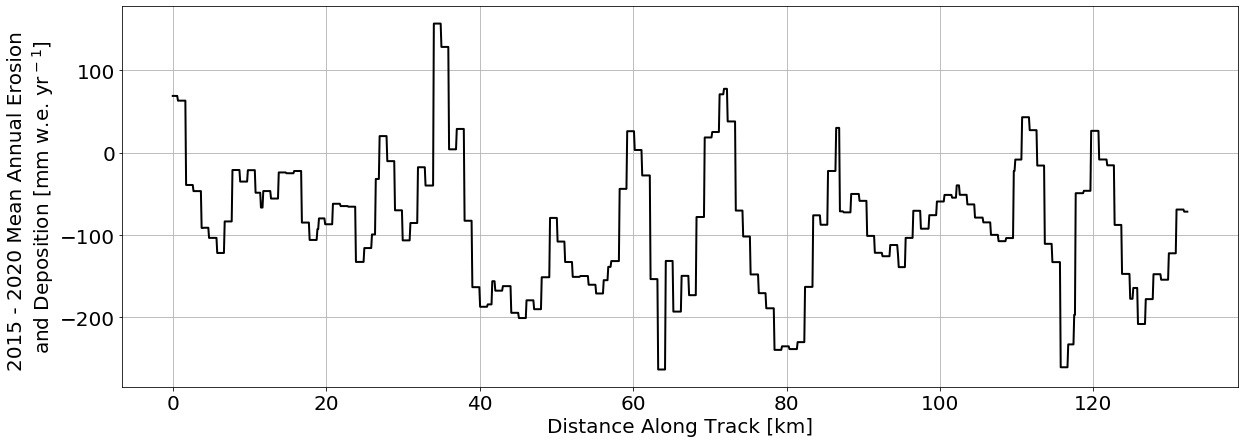

In [16]:
plt.figure(figsize=(20,7))
plt.plot(dat, ed_transect[indices], 'k', linewidth=2)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("2015 - 2020 Mean Annual Erosion \nand Deposition [mm w.e. yr$^-$$^1$]", fontsize=20)
plt.xlabel("Distance Along Track [km]", fontsize=20)
plt.savefig('images/ed_transect.pdf', format='pdf', dpi=100)